In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Base URL for UFC events
base_url = "http://ufcstats.com/statistics/events/completed?page="

# Function to get the HTML of a given page number
def get_page_html(page_number):
    url = base_url + str(page_number)
    response = requests.get(url)
    return BeautifulSoup(response.content, "html.parser")

# Scrape all pages of completed UFC events
all_events = []
page_number = 1
has_more_pages = True

while has_more_pages:
    soup = get_page_html(page_number)

    # Extract event details from the current page
    event_list = soup.find_all("a", class_="b-link b-link_style_black")
    if not event_list:
        has_more_pages = False  # Exit if no more events are found on the page
    else:
        for event in event_list:
            event_name = event.text.strip()
            event_url = event['href']
            all_events.append({"event_name": event_name, "event_url": event_url})

        page_number += 1  # Move to the next page
        time.sleep(1)  # Delay to avoid overloading the server

# Convert to DataFrame
events_df = pd.DataFrame(all_events)

# Scrape fights for each event and store them all in one list
all_fights = []
for index, row in events_df.iterrows():
    event_name = row['event_name']
    event_url = row['event_url']

    # Request the event page
    event_response = requests.get(event_url)
    event_soup = BeautifulSoup(event_response.content, "html.parser")

    # Scrape fight details (fight table)
    fight_table = event_soup.find("tbody")

    # Some pages might not have fights listed, so we check first
    if fight_table:
        for fight_row in fight_table.find_all("tr"):
            fight_data = fight_row.find_all("td")

            # Ensure the correct number of columns are present (should be 7 for each fight)
            if len(fight_data) >= 7:
                # Collect fight details
                fight_details = {
                    "event": event_name,
                    "fighter_1": fight_data[1].find_all("p")[0].text.strip(),  # First fighter name
                    "fighter_2": fight_data[1].find_all("p")[1].text.strip(),  # Second fighter name
                    "result": fight_data[0].text.strip(),  # Win/Loss
                    "method": fight_data[7].text.strip(),  # Method of victory
                    "round": fight_data[8].text.strip(),  # Round number
                    "time": fight_data[9].text.strip()  # Time of fight
                }

                # Append the fight details to the all_fights list
                all_fights.append(fight_details)


    time.sleep(1)  # 1-second delay between event scrapes

# Convert the all_fights list into a DataFrame
all_fights_df = pd.DataFrame(all_fights)

# Save the entire dataset to one CSV file
all_fights_df.to_csv("ufcfights.csv",index=False)


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV
ufcfights_not_sorted = pd.read_csv("ufcfights.csv", index_col=0)
ufcfights = ufcfights_not_sorted.reset_index()

# Sort with the most recent at the bottom
ufcfights = ufcfights.sort_index(ascending=False)

# Create unique event IDs
unique_events = ufcfights[['event']].drop_duplicates().reset_index(drop=True)

unique_events['event_id'] = range(1, len(unique_events) + 1)
ufcfights = ufcfights.merge(unique_events, on='event')

#clean up KO and Subs
ufcfights['method'] = ufcfights['method'].apply(lambda x: 'KO' if 'KO' in x else ('SUB' if 'SUB' in x else x))
# Drop unnecessary columns
ufcfights.drop(columns=["round", "time"], inplace=True)

#NEW - elo update for method
def get_k_factor(method, base_k=40):
    if method == 'KO' or method == 'SUB':
        return base_k * 1.5  # Increase K by 15% for KO or submission
    else:
        return base_k  # Default to base K for other outcomes

# Initialize Elo ratings
initial_elo = 1000
elo_ratings = {}
base_k_factor = 40
peak_elo_ratings = {}

# Function to calculate the expected score
def expected_score(elo_a, elo_b):
    return 1/(1+5**((elo_b - elo_a) / 400))

# Function to update Elo ratings
def update_elo(winner_elo, loser_elo, k_factor):
    expected_win = expected_score(winner_elo, loser_elo)
    new_winner_elo = winner_elo + k_factor * (1 - expected_win)
    new_loser_elo = loser_elo + k_factor * (0 - (1 - expected_win))
    return round(new_winner_elo, 2), round(new_loser_elo, 2)

# Create unique match IDs
ufcfights['cc_match'] = np.arange(1, len(ufcfights) + 1)

# Add columns for Elo ratings
ufcfights['fighter_1_elo_start'] = 0
ufcfights['fighter_2_elo_start'] = 0
ufcfights['fighter_1_elo_end'] = 0
ufcfights['fighter_2_elo_end'] = 0

# Calculate Elo ratings for each match
for index, row in ufcfights.iterrows():
    fighter_1 = row['fighter_1']
    fighter_2 = row['fighter_2']

    # Initialize Elo ratings if fighters are encountered for the first time
    if fighter_1 not in elo_ratings:
        elo_ratings[fighter_1] = initial_elo
    if fighter_2 not in elo_ratings:
        elo_ratings[fighter_2] = initial_elo


    # Get starting Elo ratings
    fighter_1_elo_start = elo_ratings[fighter_1]
    fighter_2_elo_start = elo_ratings[fighter_2]

    #kfactor adjust
    fight_method = row["method"]
    current_k = get_k_factor(fight_method,base_k_factor)


    # Record starting Elo ratings
    ufcfights.at[index, 'fighter_1_elo_start'] = fighter_1_elo_start
    ufcfights.at[index, 'fighter_2_elo_start'] = fighter_2_elo_start

    # Update Elo based on the result
    if row['result'] == 'win':  # Fighter 1 wins
        new_fighter1_elo, new_fighter2_elo = update_elo(fighter_1_elo_start, fighter_2_elo_start, current_k)
    elif row["result"] == 'draw':  # Draw
        new_fighter1_elo, new_fighter2_elo = update_elo(fighter_1_elo_start, fighter_2_elo_start, current_k / 2)
    else:  # No contest
        new_fighter1_elo, new_fighter2_elo = fighter_1_elo_start, fighter_2_elo_start

    if fighter_1 not in peak_elo_ratings or new_fighter1_elo > peak_elo_ratings[fighter_1]:
        peak_elo_ratings[fighter_1] = new_fighter1_elo
    if fighter_2 not in peak_elo_ratings or new_fighter2_elo > peak_elo_ratings[fighter_2]:
        peak_elo_ratings[fighter_2] = new_fighter2_elo

    # Record updated Elo ratings
    ufcfights.at[index, 'fighter_1_elo_end'] = new_fighter1_elo
    ufcfights.at[index, 'fighter_2_elo_end'] = new_fighter2_elo

    # Update Elo ratings in the dictionary
    elo_ratings[fighter_1] = new_fighter1_elo
    elo_ratings[fighter_2] = new_fighter2_elo

def get_fighter_info(fighter_name, elo_ratings, ufcfights, initial_elo=1000):
    # Check if the fighter exists in the Elo ratings dictionary
    if fighter_name in elo_ratings:
        elo = elo_ratings[fighter_name]
    else:
        elo = initial_elo

    # Find all matches where the fighter appeared as either fighter_1 or fighter_2
    fighter_matches = ufcfights[(ufcfights['fighter_1'] == fighter_name) |
                                (ufcfights['fighter_2'] == fighter_name)]

    # Return Elo rating and their matches
    if not fighter_matches.empty:
        print(f"{fighter_name}'s current Elo rating: {elo}\n")
        print(f"{fighter_name}'s matches:")
        return fighter_matches[['event', 'fighter_1', 'fighter_2', 'result', 'fighter_1_elo_start', 'fighter_2_elo_start','fighter_1_elo_end','fighter_2_elo_end']]
    else:
        return f"{fighter_name} has no recorded matches."

#finds peak elo ratings
'''

'''
# Export to CSV
'''
ufcfights.to_csv('ufcfights_with_elo.csv', index=False)
'''
'''
# Find the fighter with the highest Elo
highest_elo_fighter = max(elo_ratings, key=elo_ratings.get)
highest_elo_value = elo_ratings[highest_elo_fighter]
print(f"The fighter with the highest Elo is {highest_elo_fighter} with an Elo of {highest_elo_value}.")

#find the fghter with the lowest elo
lowest_elo_fighter = min(elo_ratings, key= elo_ratings.get)
lowest_elo_value = elo_ratings[lowest_elo_fighter]
print(f"The fighter with the highest Elo is {lowest_elo_fighter} with an Elo of {lowest_elo_value}")

top_50_fighters = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)[:50]
top_50_df = pd.DataFrame(top_50_fighters, columns=['Fighter', 'Elo Rating'])
top_50_df.to_csv('top_50_fighters_elo.csv', index=False)

fighter_name = "Anderson Silva"
fighter_info = get_fighter_info(fighter_name, elo_ratings, ufcfights)
print(fighter_info)
'''


all_fighters = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
all_fighters_df = pd.DataFrame(all_fighters, columns=['Fighter', 'Elo Rating'])
all_fighters_df.to_csv('k_factor_adjust_current.csv', index=False)

peak_elo = sorted(peak_elo_ratings.items(), key = lambda x: x[1], reverse = True)
peak_elo_df = pd.DataFrame(peak_elo, columns=['Fighter', 'Peak Elo'])
peak_elo_df.to_csv('peak_elo.csv',index=False)


<ipython-input-2-bcc4071edad6>:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.81' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ufcfights.at[index, 'fighter_1_elo_end'] = new_fighter1_elo
<ipython-input-2-bcc4071edad6>:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '968.19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ufcfights.at[index, 'fighter_2_elo_end'] = new_fighter2_elo
<ipython-input-2-bcc4071edad6>:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.81' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ufcfights.at[index, 'fighter_1_elo_start'] = fighter_1_elo_start
<ipython-input-2-bcc4071edad6>

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import difflib

# 1. Get all fighter profile links
def get_all_fighter_urls():
    url = "http://ufcstats.com/statistics/fighters"
    fighter_links = {}
    alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

    for letter in alphabet:
        page_url = f"{url}?char={letter}&page=all"
        response = requests.get(page_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        table = soup.find('table', class_='b-statistics__table')
        if table:
            for row in table.find_all('tr')[1:]:  # Skip header
                cols = row.find_all('td')
                if len(cols) > 0:
                    fighter_name = cols[0].text.strip()
                    fighter_page = cols[0].find('a')['href']
                    fighter_links[fighter_name] = fighter_page

        time.sleep(1)  # Respectful scraping

    return fighter_links

# 2. Find the closest fighter match
def find_fighter_url(fighter_name, fighter_dict):
    all_fighters = list(fighter_dict.keys())
    match = difflib.get_close_matches(fighter_name, all_fighters, n=1, cutoff=0.7)

    if match:
        matched_fighter = match[0]
        return fighter_dict[matched_fighter], matched_fighter
    else:
        return None, None

# 3. Scrape individual fighter stats
def get_fighter_details(fighter_url):
    response = requests.get(fighter_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    details = {}

    bio_info = soup.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block')
    for item in bio_info:
        if item.text.strip() != '':
            key_value = item.text.strip().split(":")
            if len(key_value) == 2:
                key = key_value[0].strip()
                value = key_value[1].strip()
                details[key] = value

    stat_blocks = soup.find_all('div', class_='b-list__info-box-left')
    if stat_blocks:
        stats = stat_blocks[0].find_all('li')
        for stat in stats:
            stat_text = stat.text.strip()
            if ':' in stat_text:
                key, value = stat_text.split(':')
                details[key.strip()] = value.strip()

    return details


In [ ]:
# 4. Scrape all fighter stats into a dictionary
def scrape_all_fighter_stats():
    fighter_links = get_all_fighter_urls()
    fighter_stats = {}

    for fighter_name, url in fighter_links.items():
        try:
            stats = get_fighter_details(url)
            fighter_stats[fighter_name] = stats
            print(f"Scraped: {fighter_name}")
        except Exception as e:
            print(f"Error scraping {fighter_name}: {e}")

        time.sleep(1)  # Be nice to the server

    return fighter_stats

# 5. Add fighter stats to the Elo dataframe
def add_fighter_stats_to_elo(ufcfights_df, fighter_stats_dict):
    new_columns = ['fighter_1_Str_Acc', 'fighter_2_Str_Acc',
                   'fighter_1_TD_Def', 'fighter_2_TD_Def',
                   'fighter_1_TD_Avg', 'fighter_2_TD_Avg']

    for col in new_columns:
        ufcfights_df[col] = None  # Create empty columns

    for index, row in ufcfights_df.iterrows():
        f1 = row['fighter_1']
        f2 = row['fighter_2']

        # Fighter 1 stats
        f1_match = difflib.get_close_matches(f1, list(fighter_stats_dict.keys()), n=1, cutoff=0.7)
        if f1_match:
            f1_stats = fighter_stats_dict[f1_match[0]]
            ufcfights_df.at[index, 'fighter_1_Str_Acc'] = f1_stats.get('Str. Acc.', None)
            ufcfights_df.at[index, 'fighter_1_TD_Def'] = f1_stats.get('TD Def.', None)
            ufcfights_df.at[index, 'fighter_1_TD_Avg'] = f1_stats.get('TD Avg.', None)

        # Fighter 2 stats
        f2_match = difflib.get_close_matches(f2, list(fighter_stats_dict.keys()), n=1, cutoff=0.7)
        if f2_match:
            f2_stats = fighter_stats_dict[f2_match[0]]
            ufcfights_df.at[index, 'fighter_2_Str_Acc'] = f2_stats.get('Str. Acc.', None)
            ufcfights_df.at[index, 'fighter_2_TD_Def'] = f2_stats.get('TD Def.', None)
            ufcfights_df.at[index, 'fighter_2_TD_Avg'] = f2_stats.get('TD Avg.', None)

    return ufcfights_df


In [ ]:
# 1. Load your existing Elo dataframe
ufcfights = pd.read_csv("ufcfights.csv")

# 2. Scrape all fighter stats
fighter_stats_dict = scrape_all_fighter_stats()

# 3. Merge stats into the Elo dataframe
ufcfights_with_stats = add_fighter_stats_to_elo(ufcfights, fighter_stats_dict)

# 4. Save it
ufcfights_with_stats.to_csv("ufcfights_with_elo_and_stats.csv", index=False)
print("✅ New dataframe saved: ufcfights_with_elo_and_stats.csv")


TypeError: 'NoneType' object is not subscriptable

In [ ]:
def get_all_fighter_urls():
    url = "http://ufcstats.com/statistics/fighters"
    fighter_links = {}
    alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

    for letter in alphabet:
        page_url = f"{url}?char={letter}&page=all"
        response = requests.get(page_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        table = soup.find('table', class_='b-statistics__table')
        if table:
            for row in table.find_all('tr')[1:]:  # Skip header
                cols = row.find_all('td')
                if len(cols) > 0 and cols[0].find('a'):
                    fighter_name = cols[0].text.strip()
                    fighter_page = cols[0].find('a')['href']
                    fighter_links[fighter_name] = fighter_page

        time.sleep(1)  # Respectful scraping

    return fighter_links


In [ ]:
def get_fighter_details(fighter_url):
    response = requests.get(fighter_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    details = {}

    # Get basic stats (Striking Acc, TD Avg, TD Defense, etc.)
    stat_blocks = soup.find_all('div', class_='b-list__info-box-left')
    if stat_blocks:
        stats = stat_blocks[0].find_all('li')
        for stat in stats:
            stat_text = stat.text.strip()
            if ':' in stat_text:
                key, value = stat_text.split(':', 1)
                details[key.strip()] = value.strip()

    # Get additional info (Height, Weight, Reach, etc.)
    bio_info = soup.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block')
    if bio_info:
        for item in bio_info:
            if item.text.strip() != '':
                key_value = item.text.strip().split(":")
                if len(key_value) == 2:
                    key = key_value[0].strip()
                    value = key_value[1].strip()
                    details[key] = value

    return details


In [ ]:
# 1. Load your existing Elo dataframe
ufcfights = pd.read_csv("ufcfights.csv")

# 2. Scrape all fighter stats
fighter_stats_dict = scrape_all_fighter_stats()

# 3. Merge stats into the Elo dataframe
ufcfights_with_stats = add_fighter_stats_to_elo(ufcfights, fighter_stats_dict)

# 4. Save it
ufcfights_with_stats.to_csv("ufcfights_with_elo_and_stats.csv", index=False)
print("✅ New dataframe saved: ufcfights_with_elo_and_stats.csv")


Scraped: Tom
Scraped: Danny
Scraped: Nariman
Scraped: David
Scraped: Hamdy
Scraped: Mansur
Scraped: Shamil
Scraped: Hiroyuki
Scraped: Daichi
Scraped: Papy
Scraped: Ricardo
Scraped: Klidson
Scraped: Cyborg
Scraped: Daniel
Scraped: John
Scraped: Scott
Scraped: Juan
Scraped: Anthony
Scraped: Zarrukh
Scraped: Israel
Scraped: Sam
Scraped: Mohamed
Scraped: Nick
Scraped: Mariya
Scraped: Kantharaj
Scraped: Marcelo
Scraped: Fabio
Scraped: Edwin
Scraped: Jessica
Scraped: Kevin
Scraped: Jesus
Scraped: Christian
Scraped: 
Scraped: Ahejiang
Scraped: Mike
Scraped: Ashiek
Scraped: Hitomi
Scraped: Omari
Scraped: Yoshihiro
Scraped: Rostem
Scraped: Razak
Scraped: Abdul-Kareem
Scraped: Mostapha
Scraped: Herdem
Scraped: Javi
Scraped: Amir
Scraped: Brett
Scraped: Junior
Scraped: Wes
Scraped: Aleksandra
Scraped: Iuri
Scraped: Ildemar
Scraped: Alfonso
Scraped: Gilbert
Scraped: Irene
Scraped: Hector
Scraped: Jose
Scraped: JJ
Scraped: Irina
Scraped: Talita
Scraped: Jim
Scraped: Houston
Scraped: Kenneth
Scraped

KeyboardInterrupt: 

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import concurrent.futures
import time

# Function to get all fighter URLs
def get_all_fighter_urls():
    url = "http://ufcstats.com/statistics/fighters"
    fighter_links = {}
    alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

    for letter in alphabet:
        page_url = f"{url}?char={letter}&page=all"
        response = requests.get(page_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        table = soup.find('table', class_='b-statistics__table')
        if table:
            for row in table.find_all('tr')[1:]:  # Skip header row
                cols = row.find_all('td')
                if len(cols) > 0 and cols[0].find('a'):
                    fighter_name = cols[0].text.strip()
                    fighter_page = cols[0].find('a')['href']
                    fighter_links[fighter_name] = fighter_page
    return fighter_links

# Function to get details for a single fighter
def get_fighter_details(fighter_name, fighter_url):
    try:
        response = requests.get(fighter_url, timeout=5)
        soup = BeautifulSoup(response.content, 'html.parser')
        details = {'Name': fighter_name}

        # Basic Stats
        stat_blocks = soup.find_all('div', class_='b-list__info-box-left')
        if stat_blocks:
            stats = stat_blocks[0].find_all('li')
            for stat in stats:
                stat_text = stat.text.strip()
                if ':' in stat_text:
                    key, value = stat_text.split(':', 1)
                    details[key.strip()] = value.strip()

        # Bio Info (Height, Weight, Reach, etc.)
        bio_info = soup.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block')
        if bio_info:
            for item in bio_info:
                if item.text.strip() != '':
                    key_value = item.text.strip().split(":")
                    if len(key_value) == 2:
                        key = key_value[0].strip()
                        value = key_value[1].strip()
                        details[key] = value

        return details

    except Exception as e:
        print(f"Error fetching {fighter_name}: {e}")
        return None

# Main fast scraping function
def fast_scrape_all_fighters():
    fighter_links = get_all_fighter_urls()
    fighter_data = []

    # Use ThreadPoolExecutor for fast parallel scraping
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(get_fighter_details, name, url) for name, url in fighter_links.items()]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result:
                fighter_data.append(result)

    return pd.DataFrame(fighter_data)

# Start scraping!
start = time.time()
fighters_df = fast_scrape_all_fighters()
end = time.time()

print(f"Scraping completed in {round(end-start,2)} seconds!")

# Save to CSV
fighters_df.to_csv('ufc_fighters_details_fast.csv', index=False)
print("Saved as ufc_fighters_details_fast.csv ✅")


Scraping completed in 85.23 seconds!
Saved as ufc_fighters_details_fast.csv ✅


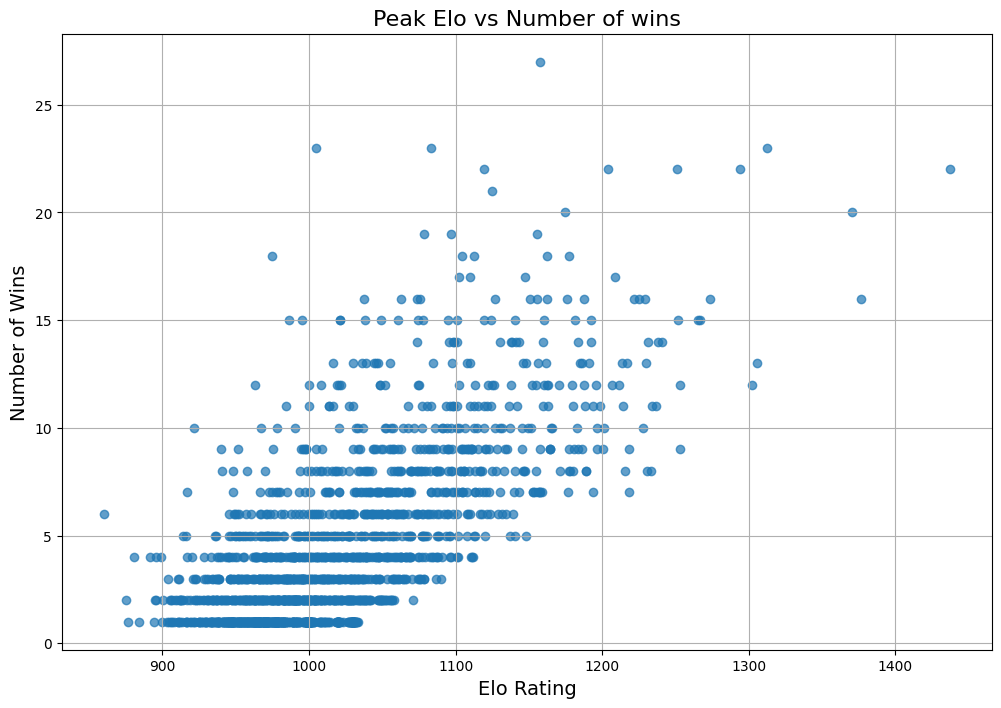

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the necessary data
ufcfights = pd.read_csv('ufcfights.csv')
elo_data = pd.read_csv('k_factor_adjust_current.csv')

# Step 1: Count number of wins per fighter
# Fighter 1 wins if result == 'win'
fighter1_wins = ufcfights[ufcfights['result'] == 'win']['fighter_1'].value_counts()

# Create a DataFrame with fighter name and number of wins
wins_df = fighter1_wins.reset_index()
wins_df.columns = ['Fighter', 'Wins']

# Step 2: Merge wins with current Elo ratings
wins_elo_df = pd.merge(wins_df, elo_data, on='Fighter', how='inner')

# Step 3: Plot
plt.figure(figsize=(12,8))
plt.scatter(wins_elo_df['Elo Rating'], wins_elo_df['Wins'], alpha=0.7)
plt.title('Peak Elo vs Number of wins', fontsize=16)
plt.xlabel('Elo Rating', fontsize=14)
plt.ylabel('Number of Wins', fontsize=14)
plt.grid(True)
plt.show()
